# Data Cleaning & Feature Engineering  
## Client Query Management System (CQMS)

This notebook documents the **data cleaning and feature engineering steps**
applied to the raw client support query dataset before loading it into MySQL.

The objective is to ensure **data consistency, integrity, and analytics readiness**
for the Client Query Management System dashboards.

## Dataset Overview

- Source: Synthetic historical support queries (CSV)
- Total Records: ~5,200
- Total Columns: 8

### Key Columns
- `query_id`
- `client_email`
- `client_mobile`
- `query_heading`
- `query_description`
- `status`
- `date_raised`
- `date_closed`

The dataset simulates real-world client support interactions, including
open and closed queries across multiple categories.


## Data Cleaning Strategy

The data cleaning process follows **industry-standard data engineering practices**:

1. Handle missing values using domain-aware logic
2. Normalize and validate categorical fields
3. Convert and engineer time-based features
4. Apply domain-specific transformations
5. Preserve realistic query lifecycle behavior
6. Prevent data leakage and redundancy

All cleaning steps are performed **before database insertion**.


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns 

## Load Raw CSV Data

In [3]:
# Load your CSV 
df = pd.read_csv("../data/raw/client_queries_5000.csv")
df.head()

,query_id,client_email,client_mobile,query_heading,query_description,status,date_raised,date_closed
0,Q0001,joshuaoneill@example.net,6638686049,Bug Report,Tab focus jumps incorrectly.,Closed,2025-02-26,2025-02-27
1,Q0002,edward91@example.net,6369365581,Bug Report,Form validation not working properly.,Closed,2025-07-22,2025-08-01
2,Q0003,cookmason@example.org,2686615523,Account Suspension,Need help lifting restrictions.,Closed,2025-06-18,2025-06-19
3,Q0004,wtaylor@example.com,4753393384,Data Export,Need monthly data dump in CSV.,Closed,2025-02-25,2025-03-07
4,Q0005,rmoore@example.net,8523755943,UI Feedback,Icons not intuitive.,Closed,2025-06-19,2025-06-20


In [4]:
df.tail()

,query_id,client_email,client_mobile,query_heading,query_description,status,date_raised,date_closed
5195,Q5196,fhenry@example.org,2758293072,Payment Failure,EMI option not available anymore.,Closed,2025-05-03,2025-05-09
5196,Q5197,robert82@example.net,2400038786,Technical Support,Freezing during screen load.,Closed,2025-05-17,2025-05-20
5197,Q5198,mclaughlinmichael@example.net,312901852,Login Issue,Forgot my password and reset isn’t working.,Closed,2025-06-25,2025-07-04
5198,Q5199,vaughnkristen@example.org,795334441,UI Feedback,Graphs too compressed on mobile view.,Closed,2025-07-15,2025-07-24
5199,Q5200,kenneth76@example.com,9953237970,Payment Failure,Payment failed due to card error.,Closed,2025-06-27,2025-07-05


In [5]:
df.describe( include='all')

,query_id,client_email,client_mobile,query_heading,query_description,status,date_raised,date_closed
count,5200,5200,5.200000e+03,5200,5200,5200,5200,5146
unique,5200,5146,NaN,10,160,2,180,195
top,Q0001,pharris@example.org,NaN,UI Feedback,Font inconsistent across pages.,Closed,2025-03-17,2025-03-07
freq,1,3,NaN,570,48,5146,45,47
mean,NaN,NaN,5.051907e+09,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,2.903568e+09,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2.393354e+06,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.539210e+09,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,5.112114e+09,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,7.599805e+09,NaN,NaN,NaN,NaN,NaN


In [6]:
df.shape

(5200, 8)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   query_id           5200 non-null   object
 1   client_email       5200 non-null   object
 2   client_mobile      5200 non-null   int64 
 3   query_heading      5200 non-null   object
 4   query_description  5200 non-null   object
 5   status             5200 non-null   object
 6   date_raised        5200 non-null   object
 7   date_closed        5146 non-null   object
dtypes: int64(1), object(7)
memory usage: 325.1+ KB


- Dataset contains ~5200 records
- `client_mobile` is numeric (should be string)
- Date columns are strings
- `date_closed` has missing values (open queries)
  

## 1. Handling Missing Values

In [8]:
df.isnull().sum()

query_id              0
client_email          0
client_mobile         0
query_heading         0
query_description     0
status                0
date_raised           0
date_closed          54
dtype: int64

In [9]:
#Missing `date_closed` indicates open queries
df['is_open'] = df['date_closed'].isnull()

In [10]:
df['is_open'].value_counts()

is_open
False    5146
True       54
Name: count, dtype: int64

## 2. Email Cleaning & Validation


In [25]:
# normalize email
df["client_email"] = df["client_email"].astype(str).str.strip().str.lower()

In [26]:
# email regex
email_pattern = re.compile(r"^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$")

In [27]:

df["is_valid_email"] = df["client_email"].apply(lambda x: bool(email_pattern.match(x))
)

In [28]:
df["is_valid_email"].value_counts()

is_valid_email
True    5200
Name: count, dtype: int64

In [ ]:
#100% valid emails, no further action needed .hmmm

## 2. Mobile Number Cleaning & Validation (Regex)

In [12]:
# convert to string
df['client_mobile'] = df['client_mobile'].astype(str)

#remove decimal points from client_id
df['client_mobile'] = df['client_mobile'].str.split('.').str[0]

In [13]:
# Strict Indian mobile regex (10 digits)
strict_pattern = re.compile(r"^[6-9]\d{9}$")

# Raw validation
df["valid_before_norm"] = df["client_mobile"].astype(str).apply(
    lambda x: bool(strict_pattern.match(x.strip()))
)

# Normalization function
def normalize_mobile(mobile):
    mobile = str(mobile).strip()
    mobile = re.sub(r"\D", "", mobile)
    if mobile.startswith("91") and len(mobile) > 10:
        mobile = mobile[-10:]
    elif mobile.startswith("0") and len(mobile) > 10:
        mobile = mobile[-10:]
    return mobile

# Apply normalization
df["normalized_mobile"] = df["client_mobile"].apply(normalize_mobile)

# Validation after normalization
df["valid_after_norm"] = df["normalized_mobile"].apply(
    lambda x: bool(strict_pattern.match(x))
)

df[["valid_before_norm", "valid_after_norm"]].head()

,valid_before_norm,valid_after_norm
0,True,True
1,True,True
2,False,False
3,False,False
4,True,True


In [14]:
before_counts = df["valid_before_norm"].value_counts()
after_counts = df["valid_after_norm"].value_counts()

before_counts, after_counts

(valid_before_norm
 False    3092
 True     2108
 Name: count, dtype: int64,
 valid_after_norm
 False    3092
 True     2108
 Name: count, dtype: int64)

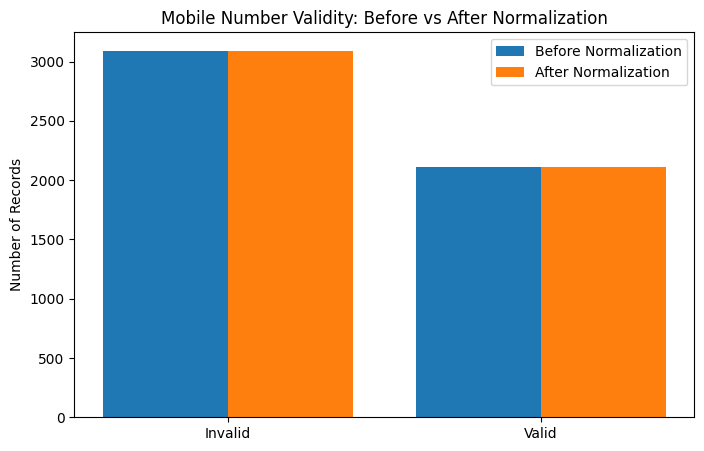

In [15]:
labels = ["Invalid", "Valid"]

before_values = [
    before_counts.get(False, 0),
    before_counts.get(True, 0)
]

after_values = [
    after_counts.get(False, 0),
    after_counts.get(True, 0)
]

x = range(len(labels))

plt.figure(figsize=(8,5))
plt.bar(x, before_values, width=0.4, label="Before Normalization")
plt.bar([i + 0.4 for i in x], after_values, width=0.4, label="After Normalization")

plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel("Number of Records")
plt.title("Mobile Number Validity: Before vs After Normalization")
plt.legend()
plt.show()


## 3. Status Normalization

In [16]:
df["status"] = df["status"].str.strip().str.capitalize()
df["status"].value_counts()

status
Closed    5146
Opened      54
Name: count, dtype: int64

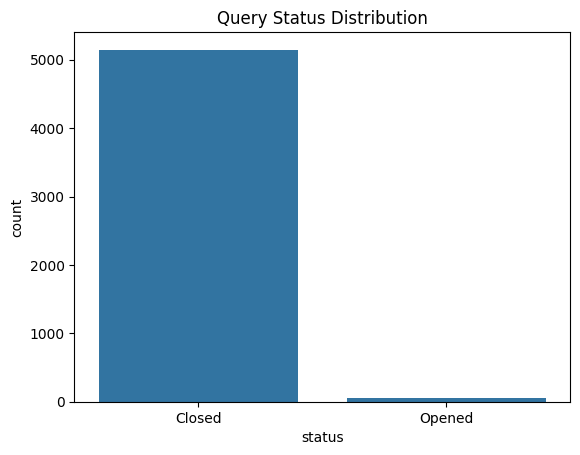

In [17]:
sns.countplot(data=df, x="status")
plt.title("Query Status Distribution")
plt.show()

## 4. Time Feature Engineering

In [18]:
df["query_created_time"] = pd.to_datetime(df["date_raised"])
df["query_closed_time"] = pd.to_datetime(df["date_closed"], errors="coerce")

In [19]:
df["resolution_time_days"] = (df["query_closed_time"] - df["query_created_time"]).dt.days


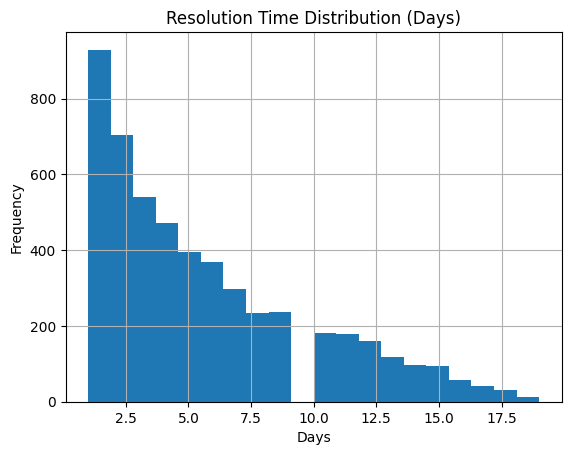

In [20]:
df["resolution_time_days"].dropna().hist(bins=20)
plt.title("Resolution Time Distribution (Days)")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()

## 5. Category Engineering

In [21]:
df["category"] = df["query_heading"]
df["category"].value_counts()

category
UI Feedback                  570
Feature Request              563
Bug Report                   544
Subscription Cancellation    528
Billing Problem              523
Account Suspension           509
Login Issue                  507
Payment Failure              497
Data Export                  493
Technical Support            466
Name: count, dtype: int64

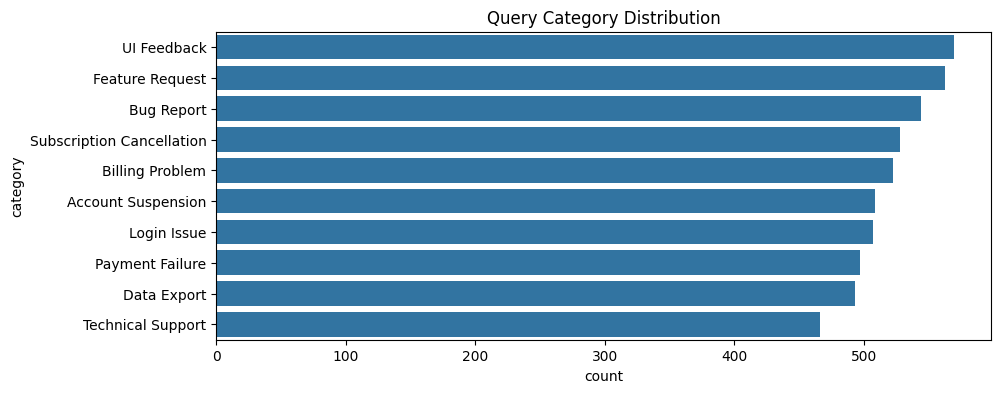

In [22]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, y="category", order=df["category"].value_counts().index)
plt.title("Query Category Distribution")
plt.show()

## 6. Duplicate & Integrity Validation

In [23]:
df["query_id"].duplicated().sum()

0

No duplicate query IDs
Safe to use as primary key

## 7. Feature Pruning & Final Dataset

In [24]:
final_df = df[
    [
        "query_id",
        "client_email",
        "client_mobile",
        "category",
        "query_heading",
        "query_description",
        "status",
        "query_created_time",
        "query_closed_time",
        "resolution_time_days"
    ]
]
final_df.head()


,query_id,client_email,client_mobile,category,query_heading,query_description,status,query_created_time,query_closed_time,resolution_time_days
0,Q0001,joshuaoneill@example.net,6638686049,Bug Report,Bug Report,Tab focus jumps incorrectly.,Closed,2025-02-26,2025-02-27,1.0
1,Q0002,edward91@example.net,6369365581,Bug Report,Bug Report,Form validation not working properly.,Closed,2025-07-22,2025-08-01,10.0
2,Q0003,cookmason@example.org,2686615523,Account Suspension,Account Suspension,Need help lifting restrictions.,Closed,2025-06-18,2025-06-19,1.0
3,Q0004,wtaylor@example.com,4753393384,Data Export,Data Export,Need monthly data dump in CSV.,Closed,2025-02-25,2025-03-07,10.0
4,Q0005,rmoore@example.net,8523755943,UI Feedback,UI Feedback,Icons not intuitive.,Closed,2025-06-19,2025-06-20,1.0


## Save

In [30]:
output_path = "../data/processed/cleaned_client_queries.csv"
df.to_csv(output_path, index=False)

print("Cleaned dataset saved:", output_path)

Cleaned dataset saved: ../data/processed/cleaned_client_queries.csv
